In [101]:
#Import libraries
library(ggplot2) # Data visualization
library(RSQLite)
library(plyr)
library(dplyr, warn.conflicts = FALSE)

#Connect to the database 
db <- dbConnect(SQLite(),"~/Downloads/soccer/database.sqlite")
Country <- dbGetQuery(db,"Select * from Country")
Match <- dbGetQuery(db,"Select * from Match")
League <- dbGetQuery(db,"Select * from League")
Team <- dbGetQuery(db,"Select * from Team")

attributes <- c(
    'player_name',
    'date',
    'Player.player_fifa_api_id',
    'Player.player_api_id',
    'height',
    'weight',
    'overall_rating',
    'preferred_foot',
    'attacking_work_rate',
    'defensive_work_rate',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'free_kick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'balance',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots',
    'aggression',
    'interceptions',
    'positioning',
    'vision',
    'penalties',
    'marking',
    'standing_tackle',
    'sliding_tackle',
    'gk_diving',
    'gk_handling',
    'gk_kicking',
    'gk_positioning',
    'gk_reflexes'
)
cols <- paste(attributes, collapse=",")
Player <- dbGetQuery(db, sprintf("SELECT %s FROM Player JOIN Player_Attributes ON Player.player_api_id = Player_Attributes.player_api_id", cols))

#Count the number of matches the particular team played at home
home_match = count(Match,home_team_api_id)
away_match = count(Match,away_team_api_id)
#change names of the column n to number of matches
names(home_match)[names(home_match)=="n"] <- "home_matches_number"
names(away_match)[names(away_match)=="n"] <- "away_matches_number"

ERROR: Error in count(Match, home_team_api_id): object 'home_team_api_id' not found


In [ ]:
head(Player)

In [ ]:
#Combine these two dataframes
new_match_data <- cbind(home_match,away_match)
#Add three new columns,
# a. total matches a particular team has played 
# b. how many matches the team has won at home and away
# c. what is the winning percentage. (wins/total_matches * 100)
new_match_data <- new_match_data %>% mutate(
    total_matches = home_matches_number + away_matches_number,
    wins = 0,
    win_percentage = 0,
    country = "",
    team_name = ""
)

#Find the country of the team and append in the country coloumn
for(row1 in rownames(new_match_data))
{
    home_indexes = which(Match$home_team_api_id == new_match_data$home_team_api_id[as.numeric(row1)])
    new_match_data$country[as.numeric(row1)] <- Country$name[Country$id==Match$country_id[as.numeric(home_indexes[1])]]
    new_match_data$team_name[as.numeric(row1)] <- Team$team_long_name[Team$team_api_id==new_match_data$home_team_api_id[as.numeric(row1)]]
}
#Drop the unnecessary columns "home_matches_number" and "away_matches_number"
drops_columns <- c("home_matches_number","away_matches_number")
new_match_data <- new_match_data[ , !(names(new_match_data) %in% drops_columns)]

print("Removed unnecessary columns")
print(head(new_match_data))

In [ ]:
#Iterate over all the teams ids 
for(id in rownames(new_match_data))
{
    #win_count stores the number of wins if the current team has scored more goals than the opponent team.
    win_count = 0 
    #Find all the records in main "Match" table which match the current team id
    home_indexes = which(Match$home_team_api_id == new_match_data$home_team_api_id[as.numeric(id)])
    away_indexes = which(Match$away_team_api_id == new_match_data$away_team_api_id[as.numeric(id)])
    
    for(i in home_indexes)
    {
        if(Match$home_team_goal[i]>Match$away_team_goal[i])
        {
            win_count = win_count +1 
        }
    }
    for(i in away_indexes)
    {
        if(Match$away_team_goal[i]>Match$home_team_goal[i])
        {
            win_count = win_count + 1
        }
    }
    
    new_match_data$wins[as.numeric(id)] <- win_count
    new_match_data$win_percentage[as.numeric(id)] <- as.double(win_count/new_match_data$total_matches[as.numeric(id)]*100)
}

#Drop Away_team_id column and change home_team_api_id columns name to team_id
drop_columns <- c("away_team_api_id")
new_match_data <- new_match_data[ , !names(new_match_data) %in% drop_columns]
names(new_match_data)[names(new_match_data)=="home_team_api_id"]<-"team_id"

#Sort the teams based on the winning percentage
sorted_data <- new_match_data[order(-new_match_data$win_percentage),]
print(sorted_data[0:10,])

In [ ]:
ggplot(data=sorted_data[0:10,], aes(x=team_name,y=win_percentage)) + 
geom_bar(stat="identity", fill="steelblue")+labs(x="Team",y="Winning percentage")+
ggtitle("Top 10 teams in all European Leagues")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [ ]:
plot_top_teams <- function(n, country) {
    league_team <- sorted_data[sorted_data$country==country,]
    league <- league_team[order(-league_team$win_percentage),][1:n,]
    ggplot(data=league,aes(x=team_name,y=win_percentage))+
    geom_bar(stat='identity',fill="firebrick ")+labs(x="Team",y="Winning Percentage")+
    ggtitle(sprintf("Top %d Teams in %s League", n, country))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
}

In [ ]:
plot_top_teams(10, "England")

In [102]:
head(Match)

id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,⋯,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,⋯,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,⋯,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,⋯,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,⋯,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,⋯,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
6,1,1,2008/2009,1,2008-09-24 00:00:00,492478,8203,8342,1,⋯,1.67,4.35,3.40,1.70,4.50,3.40,1.70,NA,NA,NA


In [103]:
team_api_id <- dbGetQuery(db, "SELECT * FROM Team WHERE team_long_name LIKE '%Barcelona%'")$team_api_id

In [104]:
home_team_matches <- dbGetQuery(db, sprintf("SELECT * FROM Match WHERE home_team_api_id = %s", team_api_id))
away_team_matches <- dbGetQuery(db, sprintf("SELECT * FROM Match WHERE away_team_api_id = %s", team_api_id))

# remove fields with nulls
home_team_matches <- na.omit(home_team_matches)
away_team_matches <- na.omit(away_team_matches)

# get the player attributes closest to the date
get_player_attributes <- function(player_api_id, match_date = Sys.Date()) {
    versions <- Player[Player$player_api_id == player_api_id,]
    versions[order(abs(difftime(versions$date, match_date))),][1,]
}

In [105]:
get_player_attributes(30955, "2013-05-29")

,player_name,date,player_fifa_api_id,player_api_id,height,weight,overall_rating,preferred_foot,attacking_work_rate,defensive_work_rate,⋯,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
12783,Andres Iniesta,2013-05-24 00:00:00,41,30955,170.18,150,90,right,high,medium,⋯,93,65,57,57,56,6,13,6,13,7


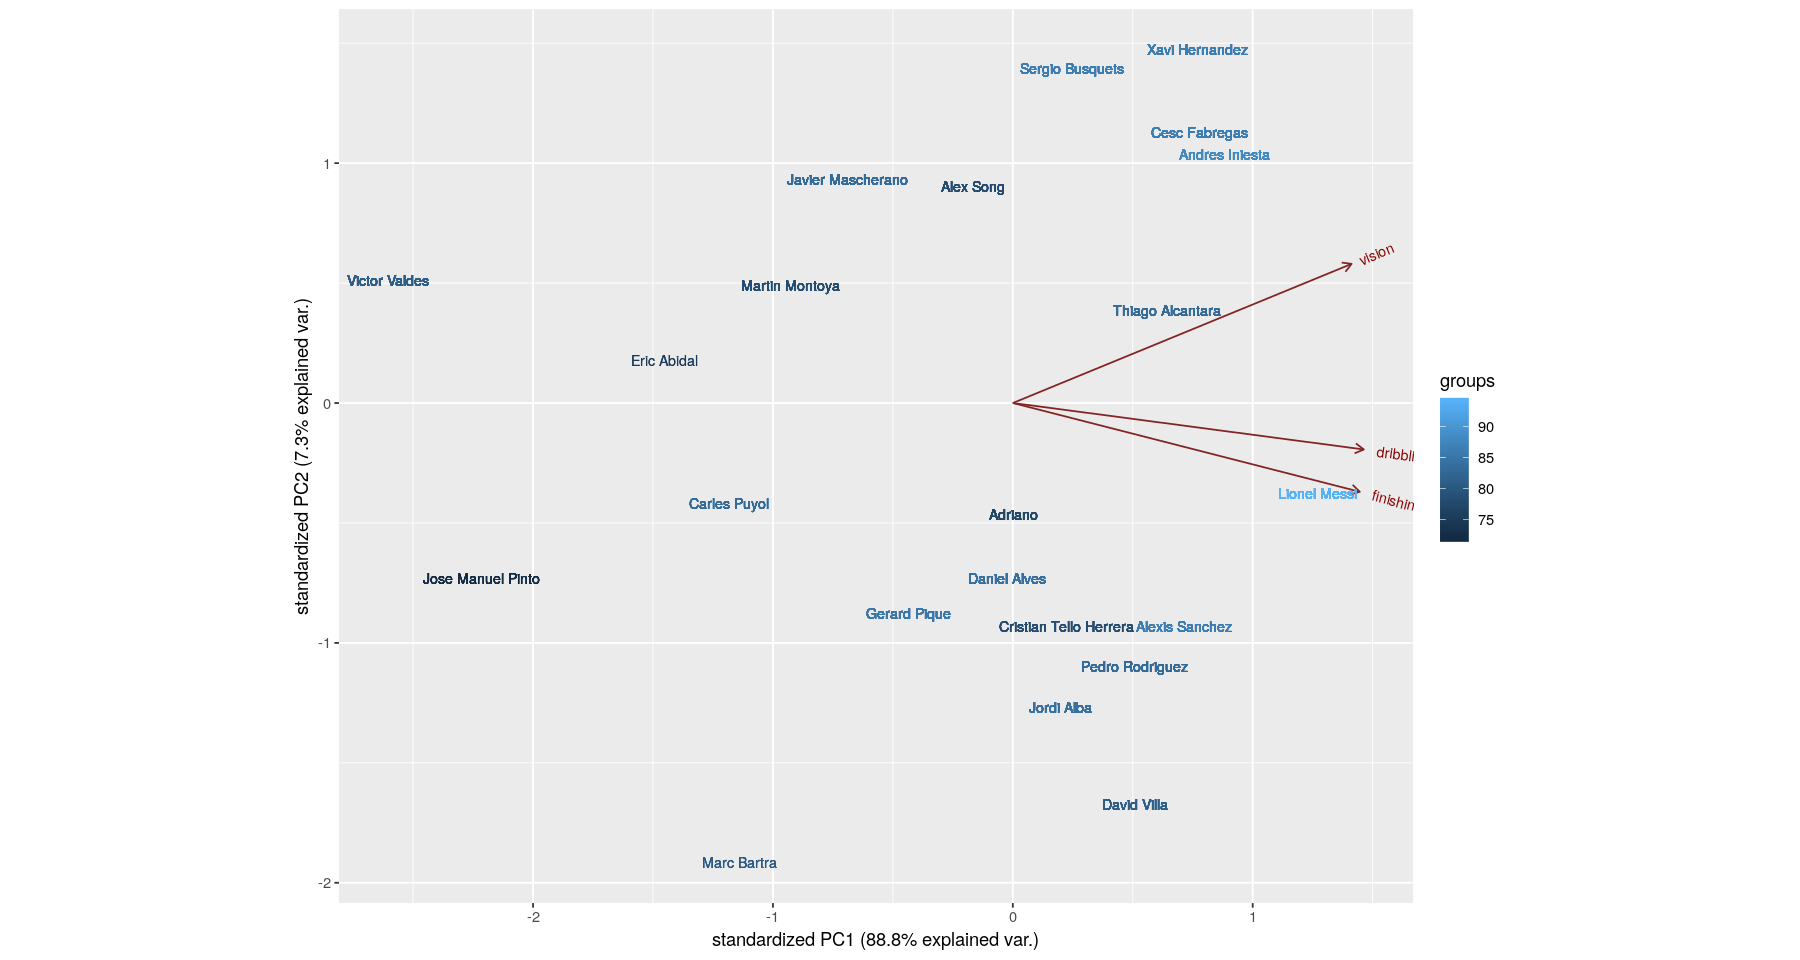

In [134]:
all_players <- list()
for (i in 1:11) {
    home_players <- as.list(home_team_matches[sprintf("home_player_%d", i)])
    away_players <- as.list(away_team_matches[sprintf("away_player_%d", i)])
    all_players <- append(unlist(all_players), unlist(home_players))
    all_players <- append(unlist(all_players), unlist(away_players))
}

options(repr.plot.width=15, repr.plot.height=8)

all_team_players <- unique(all_players)
team_df <- do.call(rbind, Map(function(x) data.frame(get_player_attributes(x)), x=all_players))
pca <- prcomp(team_df[,c('finishing', 'dribbling', 'vision')], center = TRUE,scale. = TRUE)
library(ggbiplot)
ggbiplot(pca, labels=DF$player_name, groups=team_df$overall_rating)

In [107]:
get_player_attributes(32657)

,player_name,date,player_fifa_api_id,player_api_id,height,weight,overall_rating,preferred_foot,attacking_work_rate,defensive_work_rate,⋯,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
177082,Victor Valdes,2016-05-05 00:00:00,106573,32657,182.88,172,81,right,medium,medium,⋯,38,26,10,12,10,81,78,77,84,82


In [108]:
away_team_matches["away_player_10"]

,away_player_10
77,30981
78,30981
79,30981
80,30981
81,30981
83,30981
84,30981
85,30981
86,30981
87,30981
